# _*Portfolio Diversification*_


## Introduction 

In asset management, there are broadly two approaches: active and passive investment management. Within passive investment management, there are index-tracking funds and there are approaches based on portfolio diversification, which aim at representing a portfolio with a large number of assets by a smaller number of representative stocks.
This notebook illustrates a portfolio diversification problem, which has recently become popular for two reasons:
1. it makes it possible to mimic the performance of an index (or a similarly large set of assets) with a limited budget, at limited transaction costs. That is: traditional index-tracking may purchase all assets in the index, ideally with the same weights as in the index. This may be impractical for a number of reasons: the total of even a single round lot per asset may amount to more than the assets under management, the large scale of the index-tracking problem with integrality constraints may render the optimization problem difficult, and the transaction costs of the frequent rebalancing to adjust the positions to the weights in the index may render the approach expensive. Thus, a popular approach is to select a portfolio of $q$ assets that represent the market with $n$ assets, where $q$ is significantly smaller than $n$, but where the portfolio replicates the behavior of the underlying market. To determine how to group assets into $q$ clusters and how to determine which $q$ assets should represent the $q$ clusters amounts to solving a large-scale optimization problem. In the following we describe the mathematical model for the portfolio diversification problem as introduced in [Cornuejols & Tutuncu, 2006] 
2. it allows for similarity measures between time-series beyond the covariance matrix. Notice that traditionally, modern portfolio theory considers the covariance matrix as a measure of similarity between the assets. As such, however, the covariance matrix is imperfect. Consider, for instance, a company listed both in London and New York. Although both listings should be very similar, only parts of the time series of the prices of the two listings will overlap, because of the partial overlap of the times the markets open. Instead of covariance, one can consider, for example, dynamic time warping of [Berndt and Clifford, 1994] as a measure of similarity between two time series, which allows for the fact that for some time periods, the data are captured by only one of the time series, while for others, both time series exhibit the similarity due to the parallel evolution of the stock price.

The overall workflow we demonstrate comprises:

1. pick the ground set of assets. In our case, this is a small number of US stocks.

2. load the time series capturing the evolution of the prices of assets. In our case, this is a simplistic load of adjusted daily closing price data from Wikipedia or Nasdaq or LSE or EuroNext, whereas in a real asset management, a much higher frequency may be considered.

3. compute the pair-wise similarity among the time series. In our case, we run a linear-time approximation of the dynamic time warping, still on the classical computer.

4. compute the actual portfolio of $q$ representative assets, based on the similarity measure. This step is run twice, actually. First, we obtain a reference value by a run of an IBM solver (IBM ILOG CPLEX or the Exact Eigensolver) on the classical computer. Second, we run an alternative, hybrid algorithm partly on the quantum computer.

5. visualization of the results. In our case, this is again a simplistic plot.

In the following, we first explain the model used in (4) above, before we proceed with the installation of the pre-requisites and the data loading.


## The Model

As discussed in [Cornuejols & Tutuncu, 2006], we describe a mathematical model that clusters assets into groups of similar ones and selects one representative asset from each group to be included in the index fund portfolio. The model is based on the following data, which we will discuss in more detail later:

$$
\rho_{ij} = \textrm{similarity}\, \textrm{between}\, \textrm{stock}\, i \, \textrm{and}\, \textrm{stock}\, j.
$$

For example, $\rho_{ii} = 1$, $\rho_{ij} \leq  1$ for $i \neq j$ and $\rho_{ij}$ is larger for more similar stocks. An example of this is the correlation between the returns of stocks $i$ and $j$. But one could choose other similarity indices $\rho_{ij}$.

The problem that we are interested in solving is:

$$
(M) \quad  f = \max_{x_{ij}, y_{j}} \,\, \sum_{i=1}^n \sum_{j=1}^n \rho_{ij} x_{ij}
$$

subject to the clustering constraint:

$$
\sum_{j=1}^n y_j = q,
$$

to consistency constraints:

$$
\sum_{j=1}^n x_{ij} = 1, \,\textrm{ for }\,  i = 1,\ldots, n,
\quad x_{ij} \leq y_j,\,\textrm{ for }\,  i = 1,\ldots, n; \, j = 1,\ldots, n,
\quad x_{jj} = y_j,\,\textrm{ for }\,  j = 1,\ldots, n,
$$

and integral constraints:

$$
\quad  x_{ij}, y_j \in\{0,1\}, \,\textrm{ for }\,  i = 1,\ldots, n; \, j = 1,\ldots, n.
$$

The variables $y_j$ describe which stocks $j$ are in the index fund ($y_j = 1$ if $j$ is selected in the fund, $0$ otherwise). For each stock $i = 1,\dots,n$, the variable $x_{ij}$ indicates which stock $j$ in the index fund is most similar to $i$ ($x_{ij} = 1$ if $j$ is the most similar stock in the index fund, $0$ otherwise).

The first constraint selects $q$ stocks in the fund. The second constraint imposes that each stock $i$ has exactly one representative stock $j$ in the fund. The third and fourth constraints guarantee that stock $i$ can be represented by stock $j$ only if $j$ is in the fund. The objective of the model maximizes the similarity between the $n$ stocks and their representatives in the fund. Different cost functions can also be considered. 

Let us concatenate the decision variables in one vector 

$$
{\bf z} = [x_{11},x_{12},\ldots,x_{1n}, x_{22},\ldots,x_{nn}, y_{1},\ldots,y_{n}],
$$

whose dimension is ${\bf z} \in \{0,1\}^N$, with $N = n (n+1)$ and denote the optimal solution with ${\bf z}^*$, and the optimal cost $f^*$. 


## A Hybrid Approach

Here, we demonstrate an approach that combines classical and quantum computing steps, following the quantum approximate optimization approach of Farhi, Goldstone, and Gutmann (2014). 

### Construct a binary polynomial optimization

From $(M)$ one can construct a binary polynomial optimization with equality constraints only, by substituting the $x_{ij} \leq y_j$ inequality constraints with the equivalent equality constraints $x_{ij} (1- y_j) = 0$. Then the problem becomes:

$$
(BPO) \quad  f = \max_{x_{ij}, y_{j}} \,\, \sum_{i=1}^n \sum_{j=1}^n \rho_{ij} x_{ij}
$$

subject to the clustering constraint, the integral constraints, and the following modified consistency constraints:

$$\sum_{j=1}^n x_{ij} = 1, \,\textrm{ for }\,  i = 1,\ldots, n,$$
$$\quad x_{ij} (1- y_j) = 0,\,\textrm{ for }\,  i = 1,\ldots, n; \, j = 1,\ldots, n,$$
$$\quad x_{jj} = y_j,\,\textrm{ for }\,  j = 1,\ldots, n.$$

### Construct the Ising Hamiltonian

We can now construct the Ising Hamiltonian (QUBO) by penalty methods (introducing a penalty coefficient $A$ for each equality constraint) as

$$
(IH) \quad H = \sum_{i=1}^n \sum_{j=1}^n \rho_{ij} x_{ij} + A\Big( \sum_{j=1}^n y_j - q\Big)^2 + \sum_{i=1}^n A\Big( \sum_{j=1}^n x_{ij} - 1\Big)^2 + \sum_{j=1}^n A (x_{jj}-y_j)^2 +\sum_{i=1}^n \sum_{j=1}^n A \left(x_{ij} (1- y_j)\right).
$$

### From Hamiltonian to Quadratic Programming (QP) formulation 

In the vector ${\bf z}$, the Ising Hamiltonian elements can be rewritten as follows,

First term:

$$
\sum_{i=1}^n \sum_{j=1}^n \rho_{ij} x_{ij} = [\rho_{11},\rho_{12},\ldots,\rho_{1n}, \rho_{22},\ldots,\rho_{nn}|{\bf 0}_n ]{\bf z} =: {\bf c}_0^T {\bf z}
$$

Second term:

$$
A\Big( \sum_{j=1}^n y_j - q\Big)^2 = A \Big(\sum_{j=1}^n y_j\Big)^2 - 2 Aq \sum_{j=1}^n y_j + A q^2 = A {\bf z}^T \left[\begin{array}{c}{\bf 0}_{n^2} \\ \hline  {\bf 1}_n  \end{array}\right]\left[\begin{array}{cc}{\bf 0}_{n^2} | {\bf 1}_n  \end{array}\right]{\bf z} - 2 A q [{\bf 0}_{n^2}|{\bf 1}_n]{\bf z} + A q^2 =: {\bf z}^T {\bf Q}_0 {\bf z} + {\bf c}_1^T {\bf z} + r_0
$$

Third term:

$$
\sum_{i=1}^n A\Big( \sum_{j=1}^n x_{ij} - 1\Big)^2 = A\sum_{i=1}^n \Big(\sum_{j=1}^n x_{ij}\Big)^2 - 2 A \sum_{i=1}^n\sum_{j=1}^n x_{ij} + n A = \qquad\qquad\qquad\qquad\qquad\qquad\qquad
$$

which is equivalent to: 

$$
\qquad\qquad\qquad\qquad\qquad\qquad\qquad = A {\bf z}^T \left(\sum_{i=1}^n \left[\begin{array}{c}{\bf 0}_{n(i-1)}  \\ {\bf 1}_n  \\ {\bf 0}_{n(n-i)} \\ \hline {\bf 0}_{n} \end{array}\right]\left[\begin{array}{cccc}{\bf 0}_{n(i-1)} & {\bf 1}_n  & {\bf 0}_{n(n-i)} & | {\bf 0}_{n} \end{array}\right]\right){\bf z} - 2 A [{\bf 1}_{n^2}|{\bf 0}_n]{\bf z} + n A =: {\bf z}^T {\bf Q}_1 {\bf z} + {\bf c}_2^T {\bf z} + r_1
$$

Fourth term:

$$
A \sum_{j=1}^n  (x_{jj}-y_j)^2 = A {\bf z}^T  \left(\sum_{j=0}^{n-1} \left[\begin{array}{c}{\bf 0}_{nj + j}  \\ 1  \\ {\bf 0}_{n^2-(nj+j+1)} \\ \hline {\bf 0}_{j} \\ -1 \\ {\bf 0}_{n-j-1} \end{array}\right]\left[\begin{array}{cccccc}{\bf 0}_{nj + j} & 1  & {\bf 0}_{n^2-(nj+j+1)} & | {\bf 0}_{j} & -1 & {\bf 0}_{n-j-1}  \end{array}\right]\right){\bf z} = A {\bf z}^T {\bf Q}_2 {\bf z}
$$

Fifth term:

$$
\sum_{i=1}^n \sum_{j=1}^n A \left(x_{ij} (1- y_j)\right) = A [{\bf 1}_{n^2}|{\bf 0}_n]{\bf z} + A {\bf z}^T \left( \sum_{i=1}^n \sum_{j=1}^n \left[\begin{array}{ccc|c}  &  & & \\ & {\bf 0}_{n^2\times n^2} & & -1/2_{(ij,j)}  \\ & & & \\ \hline & -1/2_{(j, ij)} &  & {\bf 0}_{n} \end{array}\right] \right) {\bf z} =:  {\bf z}^T {\bf Q}_3 {\bf z} + {\bf c}_3^T {\bf z}
$$

Therefore, the formulation becomes,

$$
(IH-QP)\quad \max_{{\bf z}\in\{0,1\}^{n(n+1)}} \, {\bf z}^T ({\bf Q}_0+{\bf Q}_1+ {\bf Q}_2 + {\bf Q}_3 ){\bf z} + ({\bf c}_0+{\bf c}_1+{\bf c}_2+{\bf c}_3)^T {\bf z} +r_0+r_1+r_2$$

which can be passed to the variational quantum eigensolver. 



## References

[1] G. Cornuejols, M. L. Fisher, and G. L. Nemhauser, *Location of bank accounts to optimize float: an analytical study of exact and approximate algorithms*, Management Science, vol. 23(8), 1997

[2] E. Farhi, J. Goldstone, S. Gutmann e-print [arXiv 1411.4028, 2014](https://arxiv.org/abs/1411.4028)

[3] G. Cornuejols and R. Tutuncu, [Optimization methods in finance](http://web.math.ku.dk/~rolf/CT_FinOpt.pdf), 2006

[4] DJ. Berndt and J. Clifford, *Using dynamic time warping to find patterns in time series*. In KDD workshop 1994  (Vol. 10, No. 16, pp. 359-370).

[5] [6_examples_max_cut_and_tsp.ipynb](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/optimization/6_examples_max_cut_and_tsp.ipynb)

## The Implementation

First, we import the requisite modules.

In [1]:
# Import requisite modules
import math
import operator
import logging
import traceback
import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Qiskit packages
import qiskit 
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
# The data providers of stock-market data
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioDiversification

Next, we download price data for two stocks and compute their pair-wise similarity matrix (<a target="_blank" href="https://en.wikipedia.org/wiki/Dynamic_time_warping">dynamic time warping</a> distance normalized to (0,1] by taking the reciprocal). If this fails, e.g., due to you being offline or exceeding the daily limit for accesses to the stock-market data, we consider a constant matrix instead.

In [2]:
# Generate a pairwise time-series similarity matrix
seed = 123

stocks = ["TICKER1", "TICKER2"]
n = len(stocks)

data = RandomDataProvider(tickers = stocks,
                 start=datetime.datetime(2016,1,1),
                 end=datetime.datetime(2016,1,30),
                 seed=seed)
data.run()
rho = data.get_similarity_matrix()

Now we decide on the number of clusters. This has to be smaller than the number of stocks we have loaded.

In [3]:
q = 1  # q less or equal than n

## Classical solution using IBM ILOG CPLEX

For a classical solution, we use IBM CPLEX. CPLEX is able to find the exact solution of this problem. We first define a ClassicalOptimizer class that encodes the problem in a way that CPLEX can solve, and then instantiate the class and solve it. 


In [4]:
class ClassicalOptimizer:
    def __init__(self, rho, n, q):

        self.rho = rho
        self.n = n  # number of inner variables
        self.q = q  # number of required selection

    def compute_allowed_combinations(self):
        f = math.factorial
        return int(f(self.n) / f(self.q) / f(self.n - self.q))

    def cplex_solution(self):

        # refactoring
        rho = self.rho
        n = self.n
        q = self.q

        my_obj = list(rho.reshape(1, n ** 2)[0]) + [0. for x in range(0, n)]
        my_ub = [1 for x in range(0, n ** 2 + n)]
        my_lb = [0 for x in range(0, n ** 2 + n)]
        my_ctype = "".join(['I' for x in range(0, n ** 2 + n)])

        my_rhs = [q] + [1 for x in range (0, n)] +[0 for x in range (0, n)] + [0.1 for x in range(0, n ** 2)]
        my_sense = "".join(['E' for x in range(0, 1+n)]) + "".join(['E' for x in range(0, n)]) + "".join(
            ['L' for x in range(0, n ** 2)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        col = [x for x in range(n**2, n**2+n)]
        coef = [1 for x in range(0, n)]
        rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0+n*ii, n+n*ii)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        for ii in range(0, n):
            col = [ii * n + ii, n ** 2 + ii]
            coef = [1, -1]
            rows.append([col, coef])

        for ii in range(0, n):
            for jj in range(0, n):
                col = [ii*n + jj, n ** 2 + jj]
                coef = [1, -1]

                rows.append([col, coef])
        
        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [5]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(rho, n, q)

# Compute the number of feasible solutions:
print('Number of feasible combinations= ' + str(classical_optimizer.compute_allowed_combinations()))

# Compute the total number of possible combinations (feasible + unfeasible)
print('Total number of combinations= ' + str(2 ** (n*(n+1))))

Number of feasible combinations= 2
Total number of combinations= 64


In [6]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.015, yc[i]), size=16, color='r')
    
    plt.grid()

    for ii in range(n ** 2, n **2 + n):

        if x[ii] > 0:
            plt.plot(xc[ii-n**2], yc[ii-n**2], 'r*', ms=20)

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            iy = ii // n
            ix = ii % n
            plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], 'C2')

    plt.title(title_str +' cost = ' + str(int(C * 100) / 100.))
    plt.show()   

Solution shows the selected stocks via the stars and in green the links (via similarities) with other stocks that are represented in the fund by the linked stock. 

## Quantum Computing with IBM Q

For the quantum solution, we use Qiskit. We first define a class QuantumOptimizer that encodes the quantum approach to solve the problem and then we instantiate it and solve it. We define the following methods inside the class:

- `exact_solution` : to make sure that the Ising Hamiltonian is correctly encoded in the $Z$ basis, we can compute its eigendecomposition classically, i.e., considering a symmetric matrix of dimension $2^N \times 2^N$. For the problem at hand $n=3$, that is $N = 12$, seems to be the limit for many laptops; 
- `vqe_solution` : solves the problem $(M)$ via the variational quantum eigensolver (VQE);
- `qaoa_solution` : solves the problem $(M)$ via a Quantum Approximate Optimization Algorithm (QAOA).

In [7]:
from qiskit.opflow import StateFn
from qiskit.utils import algorithm_globals

class QuantumOptimizer:

    def __init__(self, rho, n, q):
        self.rho = rho
        self.n = n
        self.q = q
        self.pdf = PortfolioDiversification(similarity_matrix=rho, num_assets=n, num_clusters=q)
        self.qp = self.pdf.to_quadratic_program()

    # Obtains the least eigenvalue of the Hamiltonian classically
    def exact_solution(self):
        exact_mes = NumPyMinimumEigensolver()
        exact_eigensolver = MinimumEigenOptimizer(exact_mes)
        result = exact_eigensolver.solve(self.qp)
        return self.decode_result(result)

    def vqe_solution(self):
        algorithm_globals.random_seed = 100
        backend = Aer.get_backend('statevector_simulator')
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        ry = TwoLocal(n, 'ry', 'cz', reps=5, entanglement='full')
        quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
        vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
        vqe = MinimumEigenOptimizer(vqe_mes)
        result = vqe.solve(self.qp)
        return self.decode_result(result)
        
    def qaoa_solution(self):
        algorithm_globals.random_seed = 1234
        backend = Aer.get_backend('statevector_simulator')
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
        qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        result = qaoa.solve(self.qp)
        return self.decode_result(result)

    def decode_result(self, result, offset = 0):
        quantum_solution = 1 - (result.x)
        ground_level = self.qp.objective.evaluate(result.x)
        return quantum_solution, ground_level


### Step 1

Instantiate the quantum optimizer class with parameters: 
- the similarity matrix `rho`;
- the number of assets and clusters `n` and `q`;

In [8]:
# Instantiate the quantum optimizer class with parameters: 
quantum_optimizer = QuantumOptimizer(rho, n, q)

### Step 2

Encode the problem as a binary formulation (IH-QP).

Sanity check: make sure that the binary formulation in the quantum optimizer is correct (i.e., yields the same cost given the same solution).

In [9]:
# Check if the binary representation is correct. This requires CPLEX
try: 
    import cplex
    #warnings.filterwarnings('ignore')
    quantum_solution, quantum_cost = quantum_optimizer.exact_solution()
    print(quantum_solution, quantum_cost)
    classical_solution, classical_cost = classical_optimizer.cplex_solution()
    print(classical_solution, classical_cost)
    if np.abs(quantum_cost - classical_cost) < 0.01:
        print('Binary formulation is correct')
    else: print('Error in the formulation of the Hamiltonian')
except Exception as ex:
    print(ex)

No module named 'cplex'


### Step 3

Encode the problem as an Ising Hamiltonian in the Z basis. 

Sanity check: make sure that the formulation is correct (i.e., yields the same cost given the same solution)

In [10]:
ground_state, ground_level = quantum_optimizer.exact_solution()
print(ground_state)

try:
    if np.abs(ground_level - classical_cost)<0.01:
        print('Ising Hamiltonian in Z basis is correct')
    else: print('Error in the Ising Hamiltonian formulation')
except Exception as ex:
    print(ex)

[1. 0. 1. 0. 1. 0.]
name 'classical_cost' is not defined


### Step 4

Solve the problem via VQE. Notice that depending on the number of qubits, this can take a while: for 6 qubits it takes 15 minutes on a 2015 Macbook Pro, for 12 qubits it takes more than 12 hours. For longer runs, logging may be useful to observe the workings; otherwise, you just have to wait until the solution is printed.

In [11]:
vqe_state, vqe_level = quantum_optimizer.vqe_solution()
print(vqe_state, vqe_level)

try:
    if np.linalg.norm(ground_state - vqe_state) < 0.01:
        print('VQE produces the same solution as the exact eigensolver.')
    else: print('VQE does not produce the same solution as the exact eigensolver, but that is to be expected.')
except Exception as ex:
    print(ex)

[0. 1. 0. 1. 0. 1.] 1.000779571614484
VQE does not produce the same solution as the exact eigensolver, but that is to be expected.


/Users/manoel/opt/anaconda3/envs/QiskitenvProd/lib/python3.8/site-packages/qiskit_optimization/algorithms/optimization_algorithm.py:137: UserWarning: The sum of probability of samples is not close to 1: 0.99990516095309
  warn('The sum of probability of samples is not close to 1: {}'.format(sum_prob))


### Step 5
Visualize the solution

In [12]:
xc, yc = data.get_coordinates()

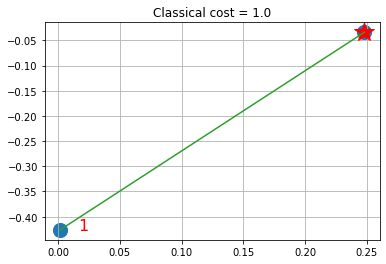

In [13]:
visualize_solution(xc, yc, ground_state, ground_level, n, q, 'Classical')

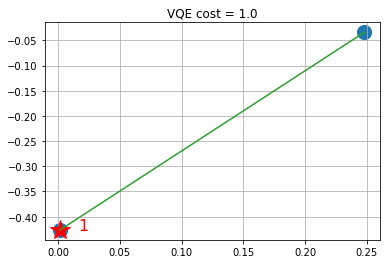

In [14]:
visualize_solution(xc, yc, vqe_state, vqe_level, n, q, 'VQE')

Solution shows the selected stocks via the stars and in green the links (via similarities) with other stocks that are represented in the fund by the linked stock. Keep in mind that VQE is a heuristic working on the QP formulation of the Ising Hamiltonian, though. For suitable choices of A, local optima of the QP formulation will be feasible solutions to the ILP. While for some small instances, as above, we can find optimal solutions of the QP formulation which coincide with optima of the ILP, finding optimal solutions of the ILP is harder than finding local optima of the QP formulation, in general. Even within the VQE, one may provide stronger guarantees, for specific variational forms (trial wave functions). 

In [15]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright